In [ ]:
import os,time
import torch
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import timm
from torch.cuda.amp import autocast, GradScalerz
from torch.nn.utils import clip_grad_norm_
import kornia.augmentation as K
from tqdm import tqdm


In [ ]:
# 1. Configuración
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Dataset 
data_dir = r'/home/pibezx/Downloads/archive/fruits-360_100x100/fruits-360'
to_tensor = transforms.ToTensor()
print("Cargando datasets...")
print(data_dir)

📁 Cargando datasets...
/home/pibezx/Downloads/archive/fruits-360_100x100/fruits-360


In [113]:
full_train_ds = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=to_tensor)
train_size = int(0.8*len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

In [114]:
test_ds   = datasets.ImageFolder(os.path.join(data_dir, 'Test'),transform=to_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,num_workers=1, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False,num_workers=1, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False,num_workers=1, pin_memory=True,persistent_workers=True)

In [115]:
classes = train_ds.dataset.classes
print(f"📊 Dataset: {len(train_ds)} train, {len(val_ds)} val, {len(test_ds)} test")
print(f"  Clases: {len(classes)} -> {classes}")

📊 Dataset: 84176 train, 21045 val, 35119 test
  Clases: 208 -> ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 

In [116]:
kornia_val = torch.nn.Sequential(
    K.Resize(size=(224, 224))
).to(device)

In [117]:
kornia_aug = torch.nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=15.0),
    K.Resize(size=(224, 224))
).to(device)

# Media y desviación de ImageNet en GPU
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

In [118]:
model = timm.create_model('vit_small_patch16_224', pretrained=True,
                          num_classes=len(classes))
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [119]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()
scaler    = GradScaler()


/tmp/ipykernel_26352/1885008583.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [120]:
def evaluate(model, data_loader, criterion, device, mean, std):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            imgs = kornia_val(imgs)
            imgs = (imgs - mean) / std
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / total
    return avg_loss, accuracy

In [121]:
# Early stopping
best_val_loss = float('inf')
patience = 5
patience_contador = 0

In [ ]:
epochs = 20
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()
    progress_bar = tqdm(train_loader, desc=f'Epoca {epoch+1}/{epochs}')
    
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Aplicar augmentaciones en GPU
        imgs = kornia_aug(imgs)
        imgs = (imgs - mean) / std
        
        # Forward pass
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Métricas
        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Actualizar barra de progreso cada 10 batches
        if i % 10 == 0:
            progress_bar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100 * correct/total:.2f}%'
            })
   
    # Calcular métricas de entrenamiento
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    epoch_time = time.time() - start_time
  
    # Validación
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, mean, std)

    # Limpiar caché de GPU
    torch.cuda.empty_cache()

    # Mostrar resultados
    print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.0f}s "
          f"- loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% "
          f"- val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_contador = 0
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print("  💾 Modelo guardado.")
    else:
        patience_contador += 1
        if patience_contador >= patience:
            print("⏳ Early stopping activado.")
            break

# Fuera del bucle de épocas: Cargar mejor modelo y evaluar en test
model.load_state_dict(torch.load('best_vit_model.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device, mean, std)
print(f"\nResultados finales en test:")
print(f"Pérdida: {test_loss:.4f} - Precisión: {test_acc:.2f}%")


/tmp/ipykernel_26352/415742978.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Época 1/10: 100%|██████████| 1316/1316 [03:07<00:00,  7.01it/s, loss=0.2522, acc=94.06%]


Epoch 1/10 - 188s - loss: 0.2516 - accuracy: 94.08% - val_loss: 0.0275 - val_accuracy: 99.10%
  💾 Modelo guardado.


Época 2/10: 100%|██████████| 1316/1316 [03:06<00:00,  7.05it/s, loss=0.0454, acc=98.78%]


Epoch 2/10 - 187s - loss: 0.0453 - accuracy: 98.78% - val_loss: 0.0253 - val_accuracy: 99.14%
  💾 Modelo guardado.


Época 3/10: 100%|██████████| 1316/1316 [03:03<00:00,  7.17it/s, loss=0.0342, acc=99.11%]


Epoch 3/10 - 184s - loss: 0.0343 - accuracy: 99.11% - val_loss: 0.0600 - val_accuracy: 99.27%


Época 4/10: 100%|██████████| 1316/1316 [03:01<00:00,  7.24it/s, loss=0.0297, acc=99.26%]


Epoch 4/10 - 182s - loss: 0.0297 - accuracy: 99.26% - val_loss: 0.0190 - val_accuracy: 99.49%
  💾 Modelo guardado.


Época 5/10: 100%|██████████| 1316/1316 [03:07<00:00,  7.01it/s, loss=0.0231, acc=99.40%]


Epoch 5/10 - 188s - loss: 0.0231 - accuracy: 99.40% - val_loss: 0.0312 - val_accuracy: 99.20%


Época 6/10: 100%|██████████| 1316/1316 [03:05<00:00,  7.09it/s, loss=0.0242, acc=99.41%]


Epoch 6/10 - 186s - loss: 0.0244 - accuracy: 99.40% - val_loss: 0.0626 - val_accuracy: 98.89%


Época 7/10: 100%|██████████| 1316/1316 [02:53<00:00,  7.59it/s, loss=0.0257, acc=99.35%]


Epoch 7/10 - 173s - loss: 0.0257 - accuracy: 99.35% - val_loss: 0.0096 - val_accuracy: 99.72%
  💾 Modelo guardado.


Época 8/10: 100%|██████████| 1316/1316 [03:05<00:00,  7.08it/s, loss=0.0195, acc=99.50%]


Epoch 8/10 - 186s - loss: 0.0196 - accuracy: 99.50% - val_loss: 0.0048 - val_accuracy: 99.83%
  💾 Modelo guardado.


Época 9/10: 100%|██████████| 1316/1316 [02:50<00:00,  7.73it/s, loss=0.0203, acc=99.52%]


Epoch 9/10 - 170s - loss: 0.0203 - accuracy: 99.52% - val_loss: 0.0213 - val_accuracy: 99.38%


Época 10/10: 100%|██████████| 1316/1316 [02:59<00:00,  7.31it/s, loss=0.0154, acc=99.59%]


Epoch 10/10 - 180s - loss: 0.0154 - accuracy: 99.59% - val_loss: 0.0014 - val_accuracy: 100.00%
  💾 Modelo guardado.


/tmp/ipykernel_26352/415742978.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))



Resultados finales en test:
Pérdida: 0.0115 - Precisión: 99.71%


Generando matriz de confusión: 100%|██████████| 549/549 [00:55<00:00,  9.96it/s]


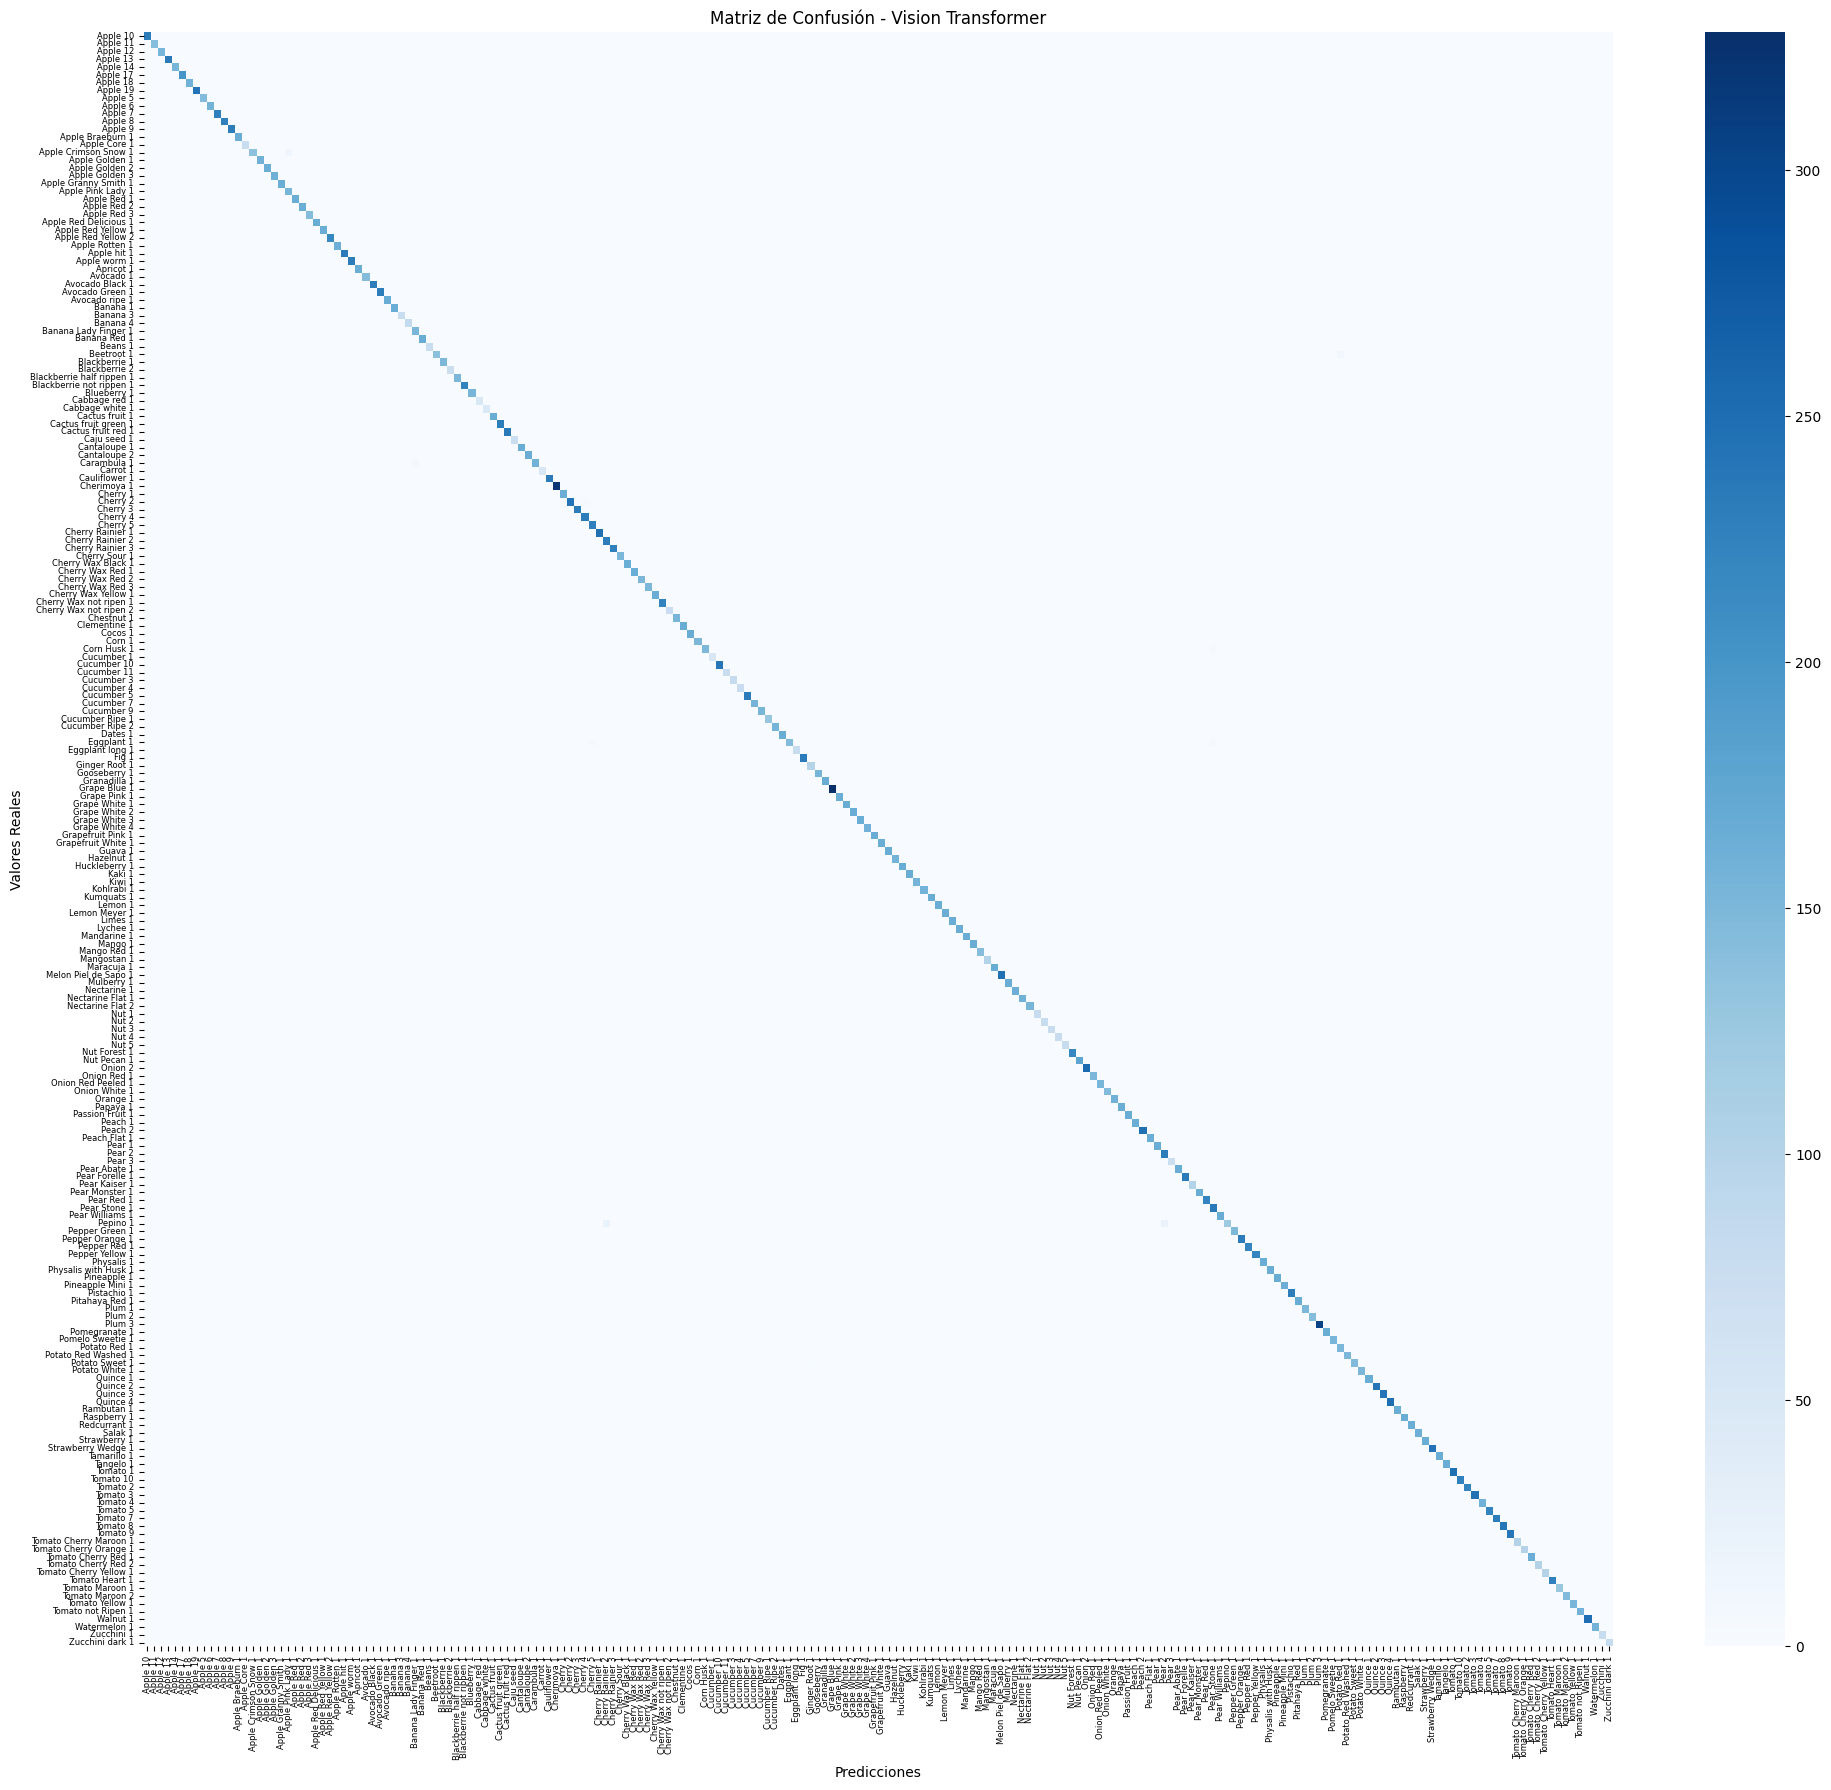

 Análisis de errores:
  Apple Crimson Snow 1     : 12 errores de 148 (8.11%)
  Beetroot 1               : 11 errores de 150 (7.33%)
  Carambula 1              : 8 errores de 166 (4.82%)
  Cherry 2                 : 5 errores de 246 (2.03%)
  Corn Husk 1              : 5 errores de 154 (3.25%)
  Eggplant 1               : 10 errores de 156 (6.41%)
  Nectarine 1              : 1 errores de 164 (0.61%)
  Pepino 1                 : 43 errores de 166 (25.90%)
  Potato Sweet 1           : 3 errores de 150 (2.00%)
  Strawberry Wedge 1       : 3 errores de 246 (1.22%)

 Confusiones más comunes:
  Pepino 1                  → Cherry Rainier 2         : 22 veces
  Pepino 1                  → Pear 2                   : 21 veces
  Apple Crimson Snow 1      → Apple Pink Lady 1        : 12 veces
  Beetroot 1                → Potato Red 1             : 11 veces
  Carambula 1               → Banana Lady Finger 1     : 8 veces
  Cherry 2                  → Cherry 4                 : 5 veces
  Corn Husk 

In [124]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confusion_matrix(model, data_loader, device, mean, std, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="Generando matriz de confusión"):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            imgs = kornia_val(imgs)
            imgs = (imgs - mean) / std
            
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualización
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - Vision Transformer')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    plt.savefig('matriz_confusion_vit.png', dpi=500, bbox_inches='tight')
    plt.show()
    
    return cm, all_preds, all_labels

# 3. Generar la matriz de confusión
cm, test_preds, test_labels = generate_confusion_matrix(model, test_loader, device, mean, std, classes)

# 4. Análisis detallado de errores
print(" Análisis de errores:")
for i in range(len(classes)):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    errors = total - correct
    if errors > 0:
        error_rate = (errors / total) * 100
        print(f"  {classes[i]:25s}: {errors} errores de {total} ({error_rate:.2f}%)")

# 5. Encontrar las confusiones más comunes
print("\n Confusiones más comunes:")
confusions = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            confusions.append((classes[i], classes[j], cm[i, j]))
            
# Ordenar por frecuencia
confusions.sort(key=lambda x: x[2], reverse=True)

for true_class, pred_class, count in confusions[:10]:  # Top 10 confusiones
    print(f"  {true_class:25s} → {pred_class:25s}: {count} veces")